# GBIF

In [73]:
using SpeciesDistributionToolkit
using CairoMakie
using Statistics
import Downloads
import Images
CairoMakie.activate!(px_per_unit = 6.0)

In [74]:
# Get occurrence data from GBIF
tx = taxon("Akodon montensis")
occ = occurrences(tx, "occurrenceStatus" => "PRESENT", "country" => "PY", "limit" => 300, "hasCoordinate" => true)
occurrences!(occ)
@info "Retrieved $(count(occ)) occurrences"

┌ Info: Retrieved 562 occurrences
└ @ Main /home/tpoisot/Documents/ms_sdt_software/appendix/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W2sZmlsZQ==.jl:5


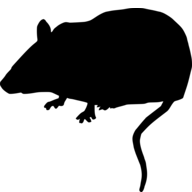

In [75]:
sp_uuid = Phylopic.imagesof(tx; items = 1)
sp_thumbnail_url = Phylopic.thumbnail(sp_uuid)
sp_thumbnail_tmp = Downloads.download(sp_thumbnail_url)
sp_image = Images.load(sp_thumbnail_tmp)

In [76]:
Phylopic.attribution(sp_uuid)

Image of *Akodon montensis* provided by [Edwin Price](https://creativecommons.org/publicdomain/zero/1.0/)


In [77]:
provider = RasterData(CHELSA2, BioClim)
spatial_extent = SpeciesDistributionToolkit.boundingbox(occ)
temperature = 0.1SDMLayer(provider; layer = "BIO1", spatial_extent...)-271
precipitation = 0.1SDMLayer(provider; layer = "BIO12", spatial_extent...)

SDM Layer with 157176 Float64 cells
	Proj string: +proj=longlat +datum=WGS84 +no_defs
	Grid size: (354, 444)

In [86]:
figure = Figure(; size = (600, 600))
ax =
    Axis(figure[1, 1]; xlabel = "Annual mean temperature (°C)", ylabel = "Annual precipitation (kg×m⁻²)")
scatter!(ax, temperature[occ], precipitation[occ], markersize=12, color=:white, strokecolor=:black, strokewidth=2)

Scatter{Tuple{Vector{Point{2, Float64}}}}

In [87]:
sp_size = Vec2f(reverse(size(sp_image) ./ 2.5))

2-element Vec{2, Float32} with indices SOneTo(2):
 76.8
 76.8

In [88]:
scatter!(ax, [22.7], [1700.0]; marker = sp_image, markersize = sp_size)

Scatter{Tuple{Vector{Point{2, Float64}}}}

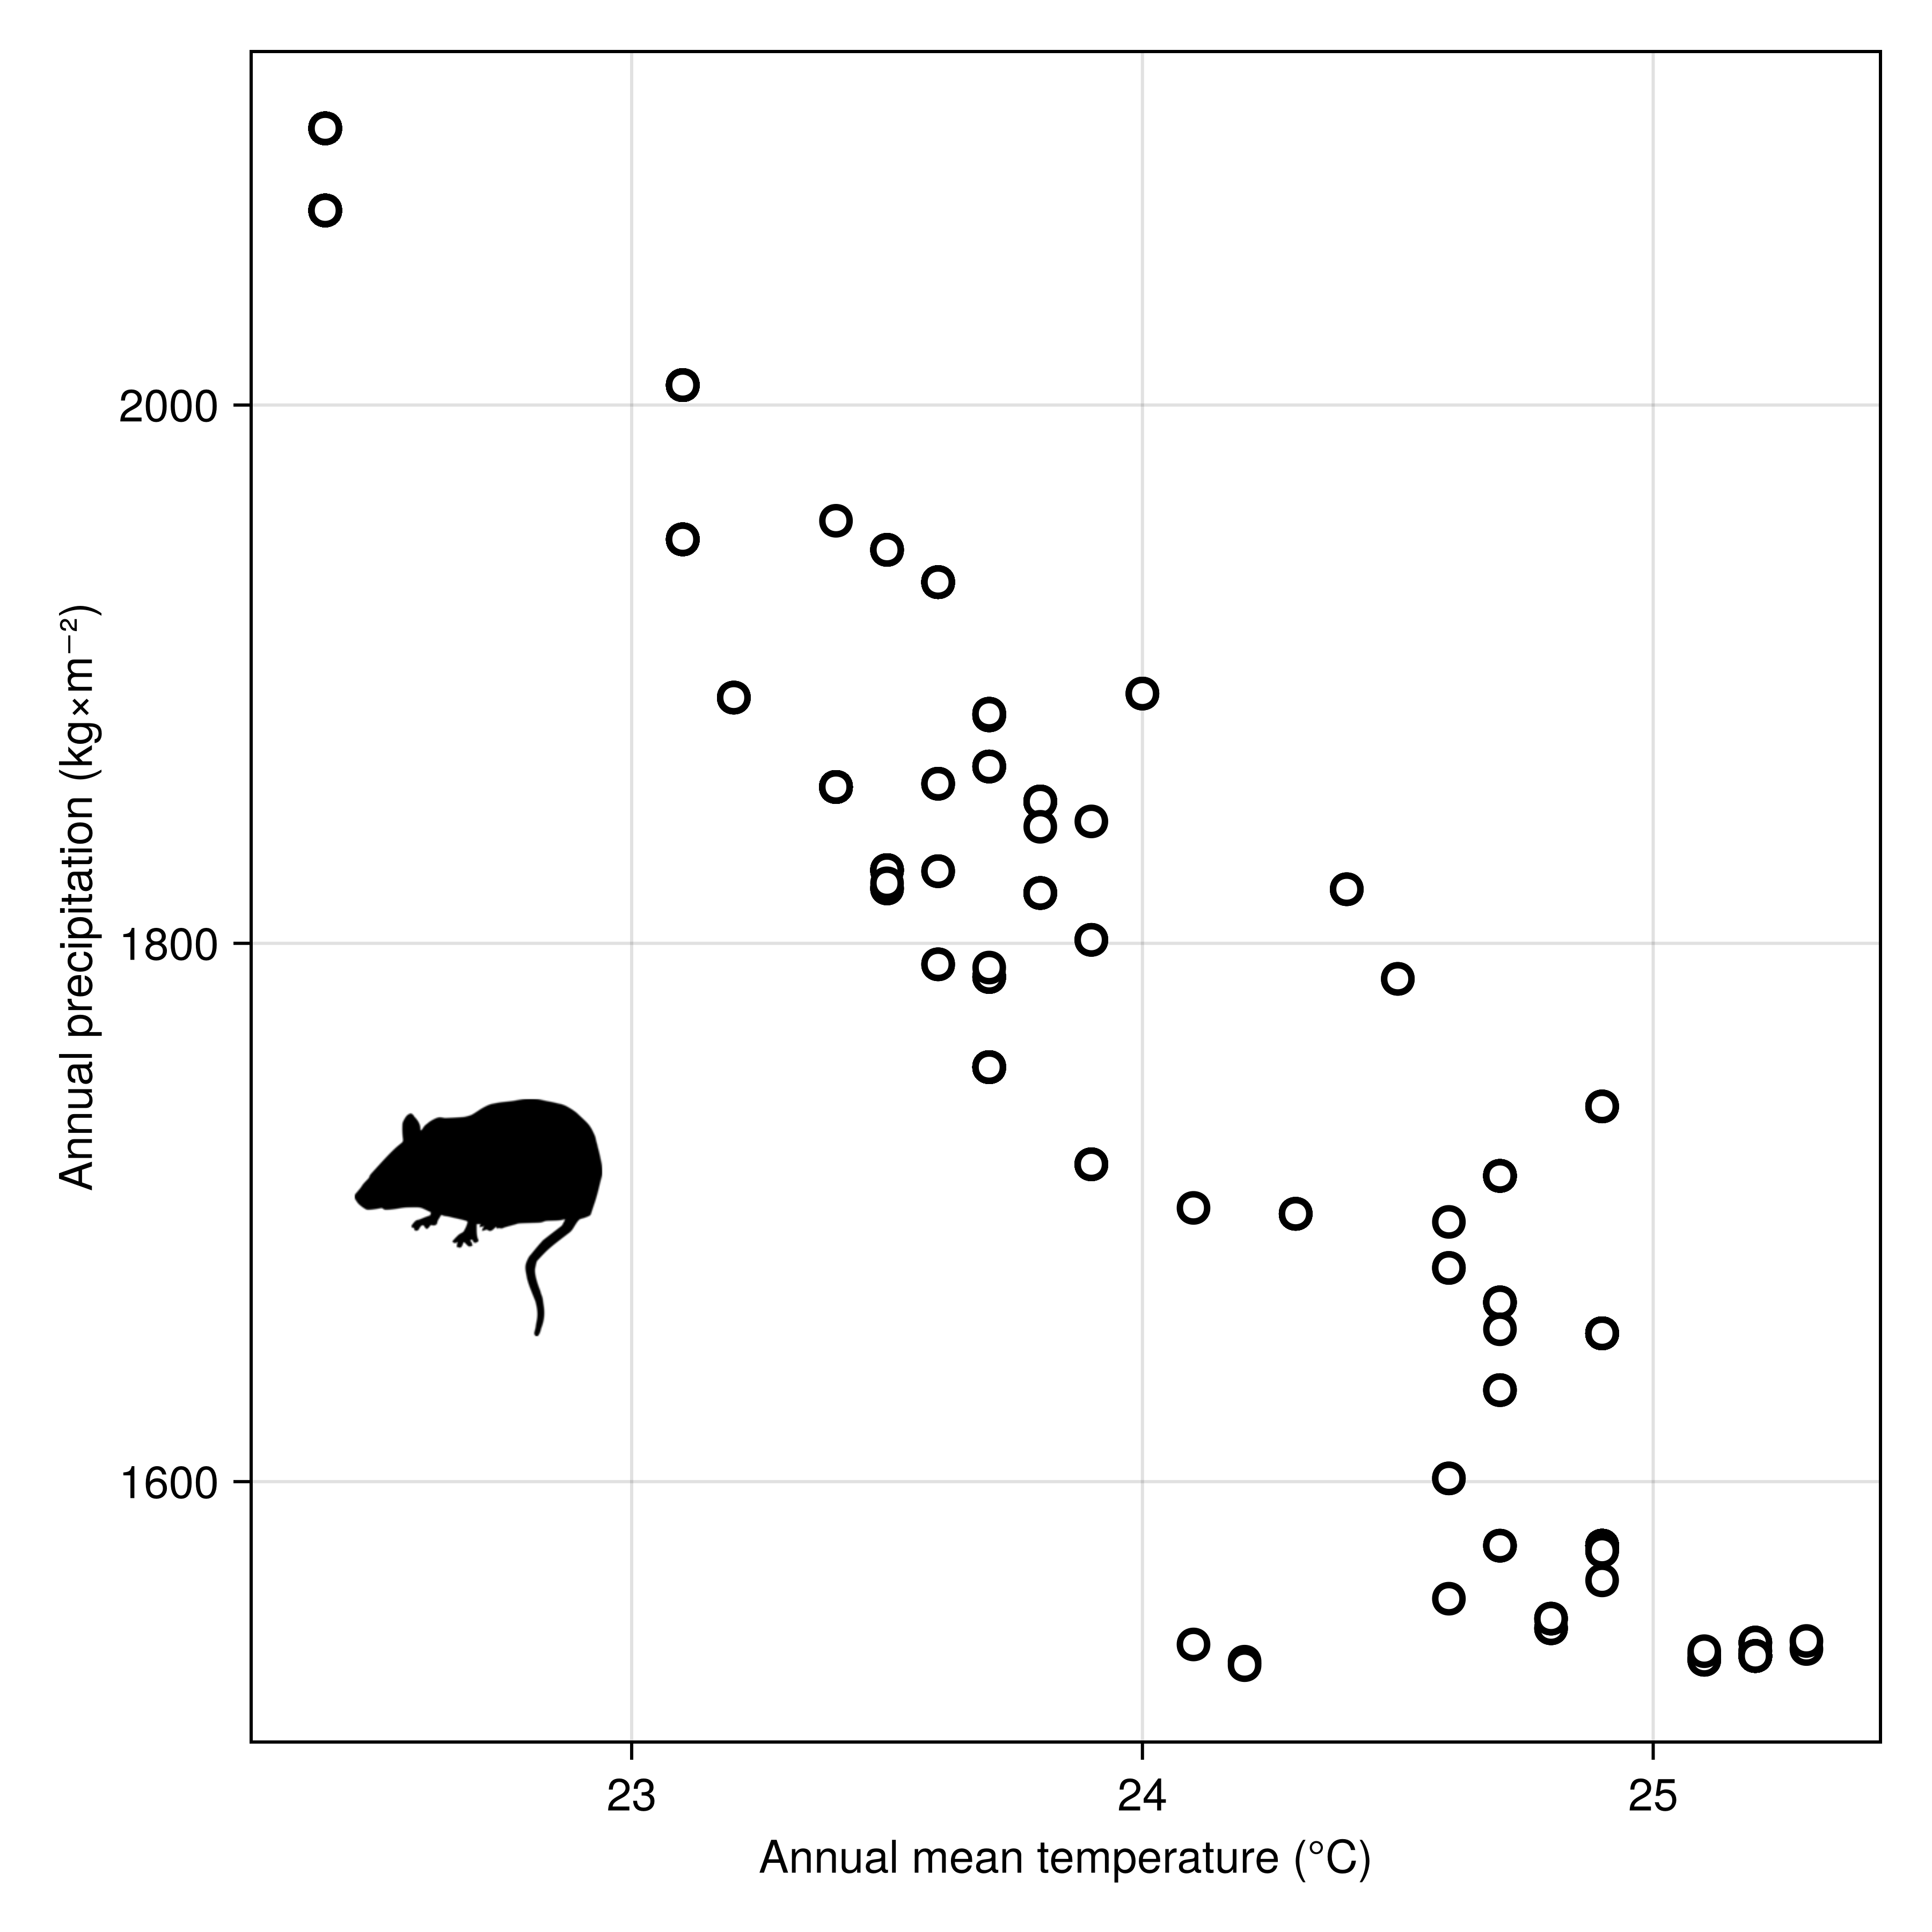

In [89]:
#| label: fig-gbif-phylopic
#| fig-cap: "yeah"
figure